# Playing with DNB data

Today, we will be working with a public data set and a public data set that is published by DNB. We will use this Jupyter notebook to work with both code and rich text elements, such as figures, links, equations, ... Because of the mix of code and text elements, these documents are the ideal place to bring together an analysis description and its results as well as they can be executed perform the data analysis in real time.

You will have to fill in the blanks at some points, run the code at others. You are free to change code or experiment. Make sure to ask us for help if you cannot come up with the solution or get stuck somewhere!

---

Some things you should know about the Jupyter notebook:

Each block that you navigate using the up and down keys is called a cell
* Hit [Shift+Enter] to execute a cell
* Hit [Enter] to edit a cell in the Edit mode. Once you are done, hit [Escape] to come back into command mode
* For a list of all shortcuts, when in command mode, hit [Ctrl+H]

Try running the cell below using the methods suggested above. You can edit the text if you like.

In [ ]:
print('Hello World')

---

## Let's get started

Great, now we're ready to start. First, we need some libraries that we use throughout this notebook. These libraries range from data analysis libraries such as Pandas to plotting libraries such as matplotlib. 

In [132]:
import pandas as pd
import numpy as np
from load_solvency import read_sheet
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fast')
plt.rcParams['figure.figsize'] = [12, 12]
from sklearn.manifold import TSNE

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils



from fbprophet import Prophet

## Read in the data

Before moving on to analysis, we need to load the data first from the internet and shape it into the right format. Let's read in data on the Euribor, the Euro Interbank Offer Rate*. We will first define the url that points to the data that we need and then use it to read the data into a Pandas dataframe.

In [11]:
url = 'https://www.emmi-benchmarks.eu/assets/modules/rateisblue/file_processing/publication/processed/hist_EURIBOR_2018.csv' 

In [12]:
euribor = pd.read_csv(url, index_col=[0])

Let's take a look at the first 10 rows.

In [13]:
euribor.head(10)

,02/01/2018,03/01/2018,04/01/2018,05/01/2018,08/01/2018,09/01/2018,10/01/2018,11/01/2018,12/01/2018,15/01/2018,...,14/12/2018,17/12/2018,18/12/2018,19/12/2018,20/12/2018,21/12/2018,24/12/2018,27/12/2018,28/12/2018,31/12/2018
1w,-0.379,-0.379,-0.378,-0.379,-0.379,-0.379,-0.379,-0.379,-0.379,-0.379,...,-0.378,-0.378,-0.378,-0.378,-0.379,-0.376,-0.375,-0.374,-0.373,-0.373
2w,-0.373,-0.374,-0.371,-0.374,-0.374,-0.375,-0.374,-0.374,-0.373,-0.373,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1m,-0.368,-0.368,-0.368,-0.369,-0.368,-0.369,-0.369,-0.369,-0.369,-0.369,...,-0.368,-0.369,-0.369,-0.369,-0.367,-0.366,-0.365,-0.364,-0.364,-0.363
2m,-0.340,-0.341,-0.339,-0.340,-0.341,-0.341,-0.341,-0.341,-0.341,-0.341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3m,-0.329,-0.329,-0.329,-0.329,-0.329,-0.329,-0.329,-0.329,-0.329,-0.329,...,-0.311,-0.311,-0.311,-0.309,-0.310,-0.310,-0.309,-0.309,-0.310,-0.309
6m,-0.271,-0.271,-0.271,-0.271,-0.271,-0.271,-0.271,-0.271,-0.271,-0.274,...,-0.238,-0.237,-0.238,-0.238,-0.238,-0.238,-0.237,-0.237,-0.236,-0.237
9m,-0.217,-0.219,-0.220,-0.219,-0.220,-0.219,-0.220,-0.217,-0.216,-0.221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12m,-0.186,-0.187,-0.187,-0.187,-0.187,-0.187,-0.186,-0.188,-0.186,-0.187,...,-0.128,-0.127,-0.125,-0.124,-0.121,-0.119,-0.118,-0.119,-0.119,-0.117


Personally, I think it makes more sense to transpose the dataframe. 

In [14]:
euribor = euribor.T

In [15]:
euribor.head(3)

,1w,2w,1m,2m,3m,6m,9m,12m
02/01/2018,-0.379,-0.373,-0.368,-0.340,-0.329,-0.271,-0.217,-0.186
03/01/2018,-0.379,-0.374,-0.368,-0.341,-0.329,-0.271,-0.219,-0.187
04/01/2018,-0.378,-0.371,-0.368,-0.339,-0.329,-0.271,-0.220,-0.187


There is a convenient function called ``describe()`` that automatically calculates some basic statistics on the ``euribor`` data set.

Usually, date columns are not parsed automatically, so we need to tell pandas to store the index column in date format. 

In [16]:
euribor.index = pd.to_datetime(euribor.index, dayfirst=True)

In [17]:
euribor.describe()

,1w,2w,1m,2m,3m,6m,9m,12m
count,255.000000,236.000000,255.000000,236.000000,255.000000,255.000000,236.000000,255.000000
mean,-0.377871,-0.372686,-0.369804,-0.338894,-0.322086,-0.266384,-0.213305,-0.173024
std,0.001494,0.002415,0.001442,0.001889,0.005400,0.008891,0.008337,0.019428
min,-0.381000,-0.379000,-0.372000,-0.342000,-0.329000,-0.279000,-0.224000,-0.193000
25%,-0.379000,-0.374000,-0.371000,-0.341000,-0.328000,-0.271000,-0.220000,-0.189000
50%,-0.378000,-0.372000,-0.370000,-0.339000,-0.321000,-0.269000,-0.216000,-0.181000
75%,-0.377000,-0.371000,-0.369000,-0.337000,-0.318000,-0.266000,-0.207000,-0.159000
max,-0.373000,-0.369000,-0.363000,-0.336000,-0.309000,-0.236000,-0.194000,-0.117000


## Visualize the data

Let's take a visual look at the data.

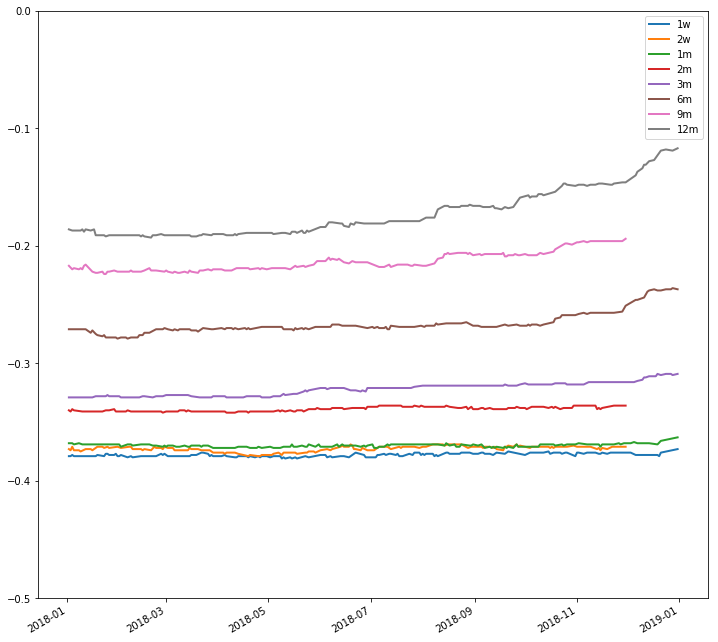

In [78]:
euribor.plot(ylim=[-0.5,0], lw=2)

## Predict the future benchmark rate

Maybe we would want to forecast how one of the benchmark rates will move in the future. One well-known way of doing this, would be using an [ARIMA model](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) to do 'time series forecasting'. Another way that we will use here is a forecasting method that was developed by Facebook called [Prophet](https://facebook.github.io/prophet/), which they use in production. Be sure to read their paper if you are interested to find out the technical details. In this notebook, you will see how easy it is to use the model.

Say we would like to know what the 1 year euribor will do in the future based on the data we have just loaded in. We first need to get the data in the right format for Prophet to be able to use the data: it expects a Dataframe with one column `ds` and one column `y`, for the dates and rates respectively. 

In [19]:
df = euribor['12m'].reset_index() # to convert the index column to a 'regular' column
df.columns = ['ds', 'y']

In [20]:
df.head(5)

,ds,y
0,2018-01-02,-0.186
1,2018-01-03,-0.187
2,2018-01-04,-0.187
3,2018-01-05,-0.187
4,2018-01-08,-0.187


We can now initialize the model and fit it to our prepared data set `df`.

In [21]:
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The model is now trained on our data. Let's create a dataframe 180 days in the future to predict the future rate.

In [22]:
future = m.make_future_dataframe(periods=180)
future.tail()

,ds
430,2019-06-25
431,2019-06-26
432,2019-06-27
433,2019-06-28
434,2019-06-29


Let's predict.

In [23]:
forecast = m.predict(future)
forecast[['ds', 'yhat']].tail()er

,ds,yhat
430,2019-06-25,-0.049369
431,2019-06-26,-0.048870
432,2019-06-27,-0.048360
433,2019-06-28,-0.047888
434,2019-06-29,-0.046263


And plot our prediction.

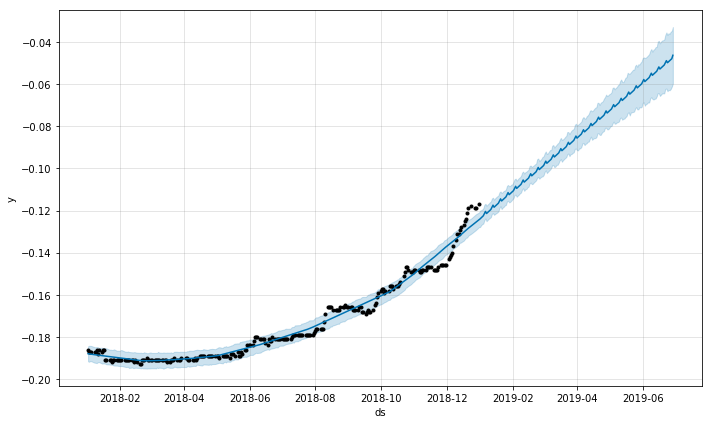

In [24]:
m.plot(forecast)
plt.show()

---

## Your turn: Solvency II data

Up and till now, you have been able to sit back and [Shift-Enter]. Now - if you have time left... - try and reuse parts of what you learned in this section to complete the exercises below. This time you'll be using a public data set published on DNB's website.

Let's start by reading in a new data set. The name of the data file is `Individuele gegevens verzekeraars per jaar.xlsx`. It contains information from https://statistiek.dnb.nl/downloads/index.aspx#/details/individuele-gegevens-verzekeraars-jaar/dataset/d66feb58-e89b-4c73-b0c7-cab81188ca77 and contains public information about insurance companies. More specifically, we use public Solvency II data from individual Dutch insurance undertakings./ 

We will walk through similar steps as before, but now, you will need to actually write some code and fill code cells to analyze the data. If you get stuck, scroll up to the relevant code you ran earlier.

Let's start by reading in the data using the name given above. 

**Exercise**: Edit line 1 such that you load in the correct file. Keep line 2 as is.

In [226]:
xls = pd.ExcelFile('Individuele gegevens verzekeraars per jaar.xlsx')
df = read_sheet(14, xls)

**Exercise:** Take a peak at the data in `df` using the `head` function.

In [227]:
df.head(3)

intangible assets  \
relatienaam                     periode                         
ABN AMRO Captive N.V.           2016-12-31                0.0   
                                2017-12-31                0.0   
ABN AMRO Levensverzekering N.V. 2016-12-31                0.0   

                                            deferred tax assets  \
relatienaam                     periode                           
ABN AMRO Captive N.V.           2016-12-31            263571.75   
                                2017-12-31            176064.65   
ABN AMRO Levensverzekering N.V. 2016-12-31                 0.00   

                                            pension benefit surplus  \
relatienaam                     periode                               
ABN AMRO Captive N.V.           2016-12-31                      0.0   
                                2017-12-31                      0.0   
ABN AMRO Levensverzekering N.V. 2016-12-31                      0.0   

                                            property, plant & equipment held for own use  \
relatienaam                     periode                                                    
ABN AMRO Captive N.V.           2016-12-31                                           0.0   
                                2017-12-31                                           0.0   
ABN AMRO Levensverzekering N.V. 2016-12-31                                           0.0   

                                            investments (other than assets held for index-linked and unit-linked contracts)  \
relatienaam                     periode                                                                                       
ABN AMRO Captive N.V.           2016-12-31                                       3.806327e+07                                 
                                2017-12-31                                       3.427627e+07                                 
ABN AMRO Levensverzekering N.V. 2016-12-31                                       1.216868e+09                                 

                                            investments (other than assets held for index-linked and unit-linked contracts)|property (other than for own use)  \
relatienaam                     periode                                                                                                                         
ABN AMRO Captive N.V.           2016-12-31                                                0.0                                                                   
                                2017-12-31                                                0.0                                                                   
ABN AMRO Levensverzekering N.V. 2016-12-31                                                0.0                                                                   

                                            investments (other than assets held for index-linked and unit-linked contracts)|holdings in related undertakings, including participations  \
relatienaam                     periode                                                                                                                                                  
ABN AMRO Captive N.V.           2016-12-31                                                0.0                                                                                            
                                2017-12-31                                                0.0                                                                                            
ABN AMRO Levensverzekering N.V. 2016-12-31                                                0.0                                                                                            

                                            investments (other than assets held for index-linked and unit-linked contracts)|equities  \
relatienaam                     periode                 

The data frame `df` now contains the data of the balance sheets of all Dutch insurance undertakings. Because Solvency II came into force in 2016 we have two years of data (per 2016-12-31 and per 2017-12-31).

Suppose we want to do some calculations with the balance sheets per 2017-12-31. 

Then we have to select this date from the data frame. For this we use the command `xs` of the `df` object. The parameters are `axis = 0` (we select from the rows), `level = 1` (level 0 is the name of the insurance undertaking and level 1 is the date of the report).

In [228]:
df = df.xs(datetime(2017,12,31), axis = 0, level = 1)

Let's see the number of insurance companies of which we have the balance sheet and how many columns of information we have:

In [229]:
nr_of_i = len(df)
nr_of_cols = len(df.columns)
print(f'The number of insurance companies in our data set is {nr_of_i} and the number of columns is {nr_of_cols}')

The number of insurance companies in our data set is 139 and the number of columns is 80


Time to find out some general things. 

**Exercise:** Calculate the sum of all total assets by selecting the `total assets` column and applying the `sum()` function and calculate the maximum `total assets`.

On to looking at insurance premiums. These are in sheet 16 of the Excel sheet we are taking a look at, so we are going to load that.

In [244]:
df_premiums = read_sheet(16, xls)
df_premiums = df_premiums.xs(datetime(2017,12,31), level = 1)

We will now use a specific algorithm to visualize the high-dimensional data: [t-Distributed Stochastic Neighbor Embedding](https://lvdmaaten.github.io/tsne/). 

In [280]:
X = df_premiums.values
Y = TSNE(n_components = 2, perplexity = 9, 
         verbose = 1, random_state = 1).fit_transform(X)

[t-SNE] Computing 28 nearest neighbors...
[t-SNE] Indexed 108 samples in 0.000s...
[t-SNE] Computed neighbors for 108 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 108 / 108
[t-SNE] Mean sigma: 8433517.286728
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.892975
[t-SNE] KL divergence after 1000 iterations: 0.187895


We can produce a scatter plot based on the results the t-SNE algorithm gives us. Uncomment the two commented lines to add the names of the insurance companies to the plot.

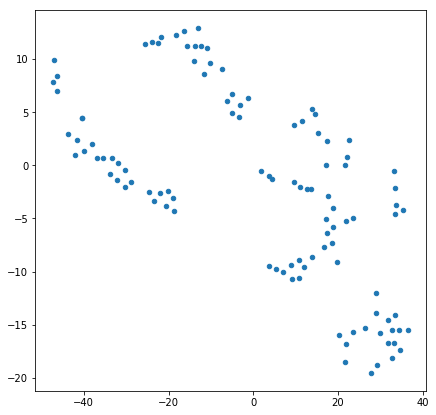

In [281]:
plt.scatter(x = Y[:, 0], 
              y = Y[:, 1], 
              s = 20)

# for i in range(len(Y[:,0])):
#     plt.annotate(df_premiums.index[i][0:20], (Y[i,0], Y[i,1]))
    


## Building a simple neural-network with Keras¶

If you have any time left, walk through the following cells of code which build a simple neural network that is learned to recognize digits. It is trained on the well known [MNIST](http://yann.lecun.com/exdb/mnist/) data set.

### Load training data

Let's look at some examples of the training data

In [260]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

11493376/11490434 [==============================] - 7s 1us/step
X_train original shape (60000, 28, 28)
y_train original shape (60000,)


Let's look at some examples of the training data.

TypeError: Invalid dimensions for image data

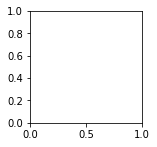

In [277]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))

### Format the data for training

Our neural-network is going to take a single vector for each training example, so we need to reshape the input so that each 28x28 image becomes a single 784 dimensional vector. We'll also scale the inputs to be in the range [0-1] rather than [0-255].

In [263]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)



Modify the target matrices to be in the one-hot format, i.e.


    
    0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0],
    1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0],
    2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0],
    etc.
       

In [264]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

Build the neural-network. Here we'll do a simple 3 layer fully connected network.

![Neural Net](figure.png)

In [265]:
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu')) # An "activation" is just a non-linear function applied to the output
                              # of the layer above. Here, with a "rectified linear unit",
                              # we clamp all values below 0 to 0.
                           
model.add(Dropout(0.2))   # Dropout helps protect the model from memorizing or "overfitting" the training data
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax')) # This special "softmax" activation among other things,
                                 # ensures the output is a valid probaility distribution, that is
                                 # that its values are all non-negative and sum to 1.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Compile the model

Keras is built on top of Theano (and now TensorFlow as well), both packages that allow you to define a computation graph in Python, which they then compile and run efficiently on the CPU or GPU without the overhead of the Python interpreter.

When compiling a model, Keras asks you to specify your loss function and your optimizer. The loss function we'll use here is called categorical crossentropy, and is a loss function well-suited to comparing two probability distributions.

Here our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. More detail at Wikipedia

The optimizer helps determine how quickly the model learns, how resistent it is to getting "stuck" or "blowing up". We won't discuss this in too much detail, but "adam" is often a good choice (developed here at U of T).

In [266]:
model.compile(loss='categorical_crossentropy', optimizer='adam')


### Train the model

This is the fun part: you can feed the training data loaded in earlier into this model and it will learn to classify digits.

In [269]:
model.fit(X_train, Y_train,
          batch_size=128, epochs=4, verbose=1,
          validation_data=(X_test, Y_test))

Instructions for updating:
Use tf.cast instead.


Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 6s 99us/step - loss: 0.2505 - val_loss: 0.1036
Epoch 2/4
60000/60000 [==============================] - 5s 90us/step - loss: 0.1032 - val_loss: 0.0812
Epoch 3/4
60000/60000 [==============================] - 5s 89us/step - loss: 0.0732 - val_loss: 0.0737
Epoch 4/4
60000/60000 [==============================] - 5s 87us/step - loss: 0.0571 - val_loss: 0.0790


### Finally, evaluate its performance.

In [273]:
score = model.evaluate(X_test, Y_test, verbose=0)
print(score)

0.07898827891027323


### Inspecting the output

It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

In [274]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

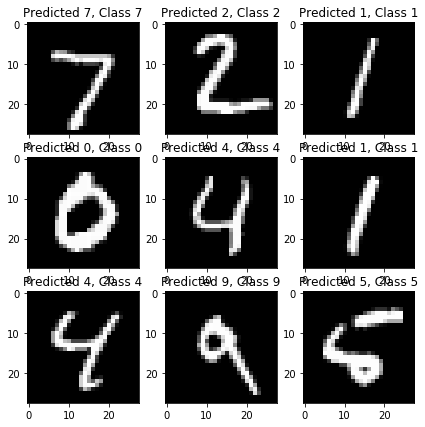

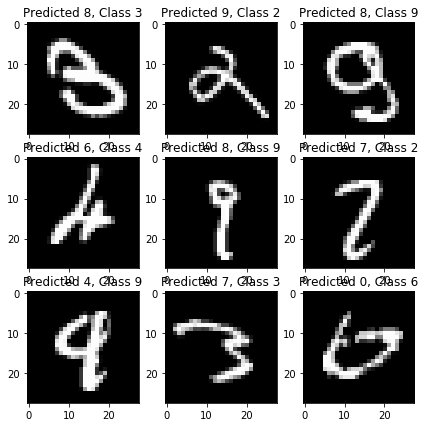

In [275]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

# Glossary & References

* Euribor, or the Euro Interbank Offer Rate, is a reference rate that is constructed from the average interest rate at which eurozone banks offer unsecured short-term lending on the inter-bank market (https://www.investopedia.com/terms/e/euribor.asp).
* [Python Exercises](https://github.com/iitmcvg/Python-Exercises/)
* [Prophet: forecasting at scale](https://research.fb.com/prophet-forecasting-at-scale/)
* Last part based on: https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb

